# Data Analytics
http://www.moj.go.jp/housei/toukei/toukei_ichiran_nyukan.html#a02

+ 出典：法務省 「出入国管理統計統計表」 (http://www.moj.go.jp/housei/toukei/toukei_ichiran_nyukan.html)
+ （注）「協定該当者」とは，「日本国における合衆国軍隊の地位に関する協定」（昭和35年条約第７号）及び「日本国における国際連合の軍隊の地位に関する協定」（昭和29年条約第12号）による軍人，軍属及びその家族で，軍艦又は軍用機によらないで日本に入出国した者である。

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import json

# View Graph Libs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter

# View Graph Settings
fp = FontProperties(fname = r'C:\WINDOWS\Fonts\meiryo.ttc', size = 3)
commaform = FuncFormatter(lambda x, p: format(int(x), ','))
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

# Data Dir
outputPath = os.path.dirname(os.getcwd()) + r'\Output'
dataPath = os.path.dirname(os.getcwd()) + r'\Data'

In [3]:
%%time
## Wall time: 7.81 s

files = [f for f in glob.glob(dataPath + r'/Modified/*.xls*')]
data_raw = pd.DataFrame()
for f in files:
    df = pd.read_excel(f, encoding = 'utf-8')
    df['year'] = f.split('.')[0][-8:-6]                # ファイル名から該当年を判断
    df['month'] = f.split('.')[0][-5:-3]                 # ファイル名から該当月を判断
    df['year_month'] = df['year'] + "-" + df['month']
    df['year_month'] = pd.to_datetime(df['year_month'], format = '%y-%m')
    data_raw = pd.concat([data_raw, df], axis = 0).reset_index(drop = True)
data_raw = data_raw.replace('-', 0)                      # テキストで入っている場合は除く

Wall time: 47.2 s


In [4]:
data_raw.head()

,港,総数,入国計,入国日本人,入国外国人,入国協定該当者,出国計,出国日本人,出国外国人,出国協定該当者,year,month,year_month
0,釧路,0,0,0,0.0,0,0,0,0.0,0,07,01,2007-01-01
1,稚内,0,0,0,0.0,0,0,0,0.0,0,07,01,2007-01-01
2,根室,0,0,0,0.0,0,0,0,0.0,0,07,01,2007-01-01
3,小樽,94,56,1,55.0,0,38,0,38.0,0,07,01,2007-01-01
4,室蘭,2,0,0,0.0,0,2,0,2.0,0,07,01,2007-01-01


## Json に変換

In [77]:
toJson = data_raw.copy()
toJson = toJson[['港', 'year_month', '入国日本人', '入国外国人', '入国協定該当者', '出国日本人', '出国外国人', '出国協定該当者']].fillna(0)

# データ型の変換
toJson['port'] = toJson['港'].astype(str)
toJson['date'] = toJson['year_month'].astype(str)
toJson['in_jp'] = toJson['入国日本人'].astype(int)
toJson['in_fr'] = toJson['入国外国人'].astype(int)
toJson['in_tr'] = toJson['入国協定該当者'].astype(int)
toJson['em_jp'] = toJson['出国日本人'].astype(int)
toJson['em_fr'] = toJson['出国外国人'].astype(int)
toJson['em_tr'] = toJson['出国協定該当者'].astype(int)

# 全港合計データ追加
all_sum = toJson.groupby('date')[['in_jp', 'in_fr', 'in_tr', 'em_jp', 'em_fr', 'em_tr']].sum().reset_index()
all_sum['port'] = 'all'
toJson = pd.concat([toJson, all_sum], sort = False).sort_values(['port', 'date'])

# json 変換
toJson = toJson.groupby('date')[['port', 'in_jp', 'in_fr', 'in_tr', 'em_jp', 'em_fr', 'em_tr']].apply(lambda x: x.set_index('port').to_dict(orient = 'index'))
j = toJson.to_json(orient = 'index', force_ascii = False)
#print(json.dumps(json.loads(j), indent = 2, sort_keys = True, ensure_ascii = False))

In [78]:
# 出力
with open(outputPath + r'/data.json', 'w', encoding = 'utf-8') as f:
    json.dump(json.loads(j), f, indent = 4, ensure_ascii = False)

## 月次 出入国者推移 属性別

In [4]:
# データ作成
data_em_japanese = data_raw[['year_month' , '出国日本人']].groupby(['year_month']).sum().reset_index()
data_im_japanese = data_raw[['year_month' , '入国日本人']].groupby(['year_month']).sum().reset_index()

data_em_foreigners = data_raw[['year_month' , '出国外国人']].groupby(['year_month']).sum().reset_index()
data_im_foreigners = data_raw[['year_month' , '入国外国人']].groupby(['year_month']).sum().reset_index()

data_em_eligible_foreigners = data_raw[['year_month' , '出国協定該当者']].groupby(['year_month']).sum().reset_index()
data_im_eligible_foreigners = data_raw[['year_month' , '入国協定該当者']].groupby(['year_month']).sum().reset_index()

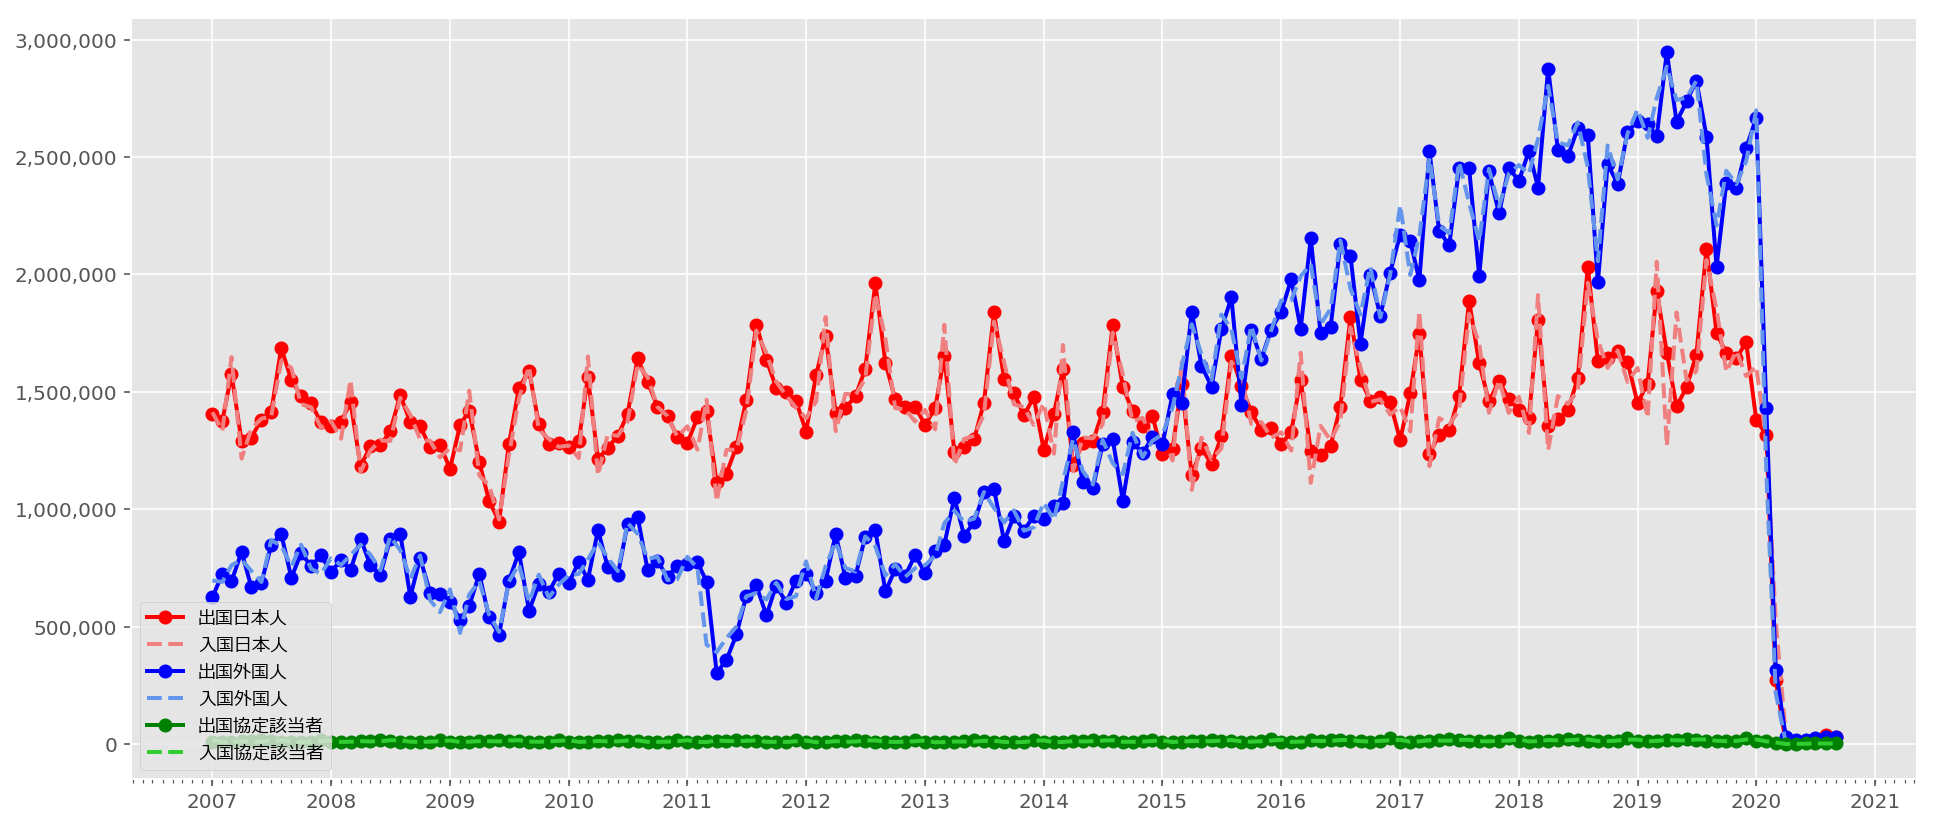

In [5]:
# 表定義
fig, ax1 = plt.subplots(figsize = (16, 7))
fp = FontProperties(fname = r'C:\WINDOWS\Fonts\meiryo.ttc', size = 9)

# 日本人
ax1.plot(data_em_japanese['year_month'],
         data_em_japanese['出国日本人'],
         '.-',
         color = 'r',
         linewidth = 2,
         markersize = 12)

ax1.plot(data_im_japanese['year_month'],
         data_im_japanese['入国日本人'],
         '--',
         color = 'lightcoral',
         linewidth = 2,
         markersize = 12)

# 外国人
ax1.plot(data_em_foreigners['year_month'],
         data_em_foreigners['出国外国人'],
         '.-',
         color = 'b',
         linewidth = 2,
         markersize = 12)

ax1.plot(data_im_foreigners['year_month'],
         data_im_foreigners['入国外国人'],
         '--',
         color = 'cornflowerblue',
         linewidth = 2,
         markersize = 12)

# 協定該当者
ax1.plot(data_em_eligible_foreigners['year_month'],
         data_em_eligible_foreigners['出国協定該当者'],
         '.-',
         color = 'g',
         linewidth = 2,
         markersize = 12)

ax1.plot(data_im_eligible_foreigners['year_month'],
         data_im_eligible_foreigners['入国協定該当者'],
         '--',
         color = 'limegreen',
         linewidth = 2,
         markersize = 12)

ax1.get_xaxis().set_major_locator(mdates.YearLocator(base=1))
ax1.get_xaxis().set_minor_locator(mdates.MonthLocator())

ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.legend(prop = fp, loc = 'lower left');

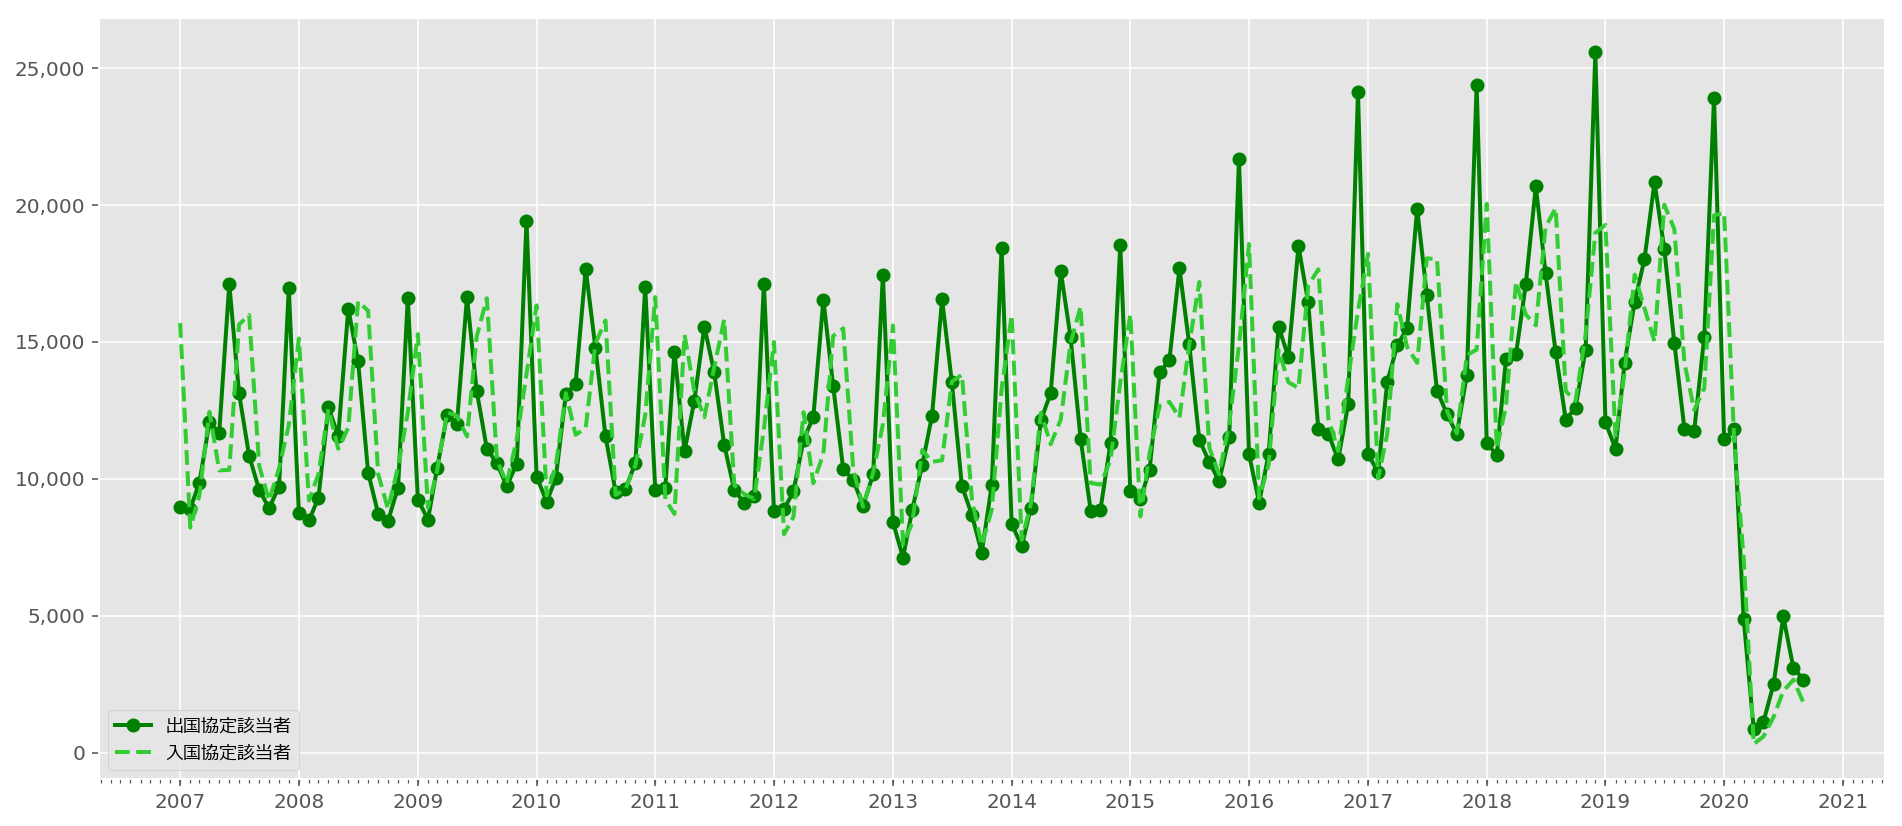

In [6]:
# 表定義
fig, ax1 = plt.subplots(figsize = (16, 7))
fp = FontProperties(fname = r'C:\WINDOWS\Fonts\meiryo.ttc', size = 9)

# 協定該当者
ax1.plot(data_em_eligible_foreigners['year_month'],
         data_em_eligible_foreigners['出国協定該当者'],
         '.-',
         color = 'g',
         linewidth = 2,
         markersize = 12)

ax1.plot(data_im_eligible_foreigners['year_month'],
         data_im_eligible_foreigners['入国協定該当者'],
         '--',
         color = 'limegreen',
         linewidth = 2,
         markersize = 12)

ax1.get_xaxis().set_major_locator(mdates.YearLocator(base=1))
ax1.get_xaxis().set_minor_locator(mdates.MonthLocator())

ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.legend(prop = fp, loc = 'lower left');

In [7]:
target_col = ['year_month', '港', '入国日本人', '入国外国人', '入国協定該当者', '出国日本人', '出国外国人', '出国協定該当者']
int_col = ['入国日本人', '入国外国人', '入国協定該当者', '出国日本人', '出国外国人', '出国協定該当者']

export_data = data_raw[target_col].copy()

from urllib.parse import unquote
export_data['港'] = [unquote(str(x)) for x in export_data['港']]
export_data['year_month'] = export_data['year_month'].astype(str)
export_data[int_col] = export_data[int_col].fillna(0.0).astype(int)

export_data.columns = ['date', 'port', 'in_jp', 'in_fr', 'in_tr', 'em_jp', 'em_fr', 'em_tr']
export_data.head()

,date,port,in_jp,in_fr,in_tr,em_jp,em_fr,em_tr
0,2007-01-01,釧路,0,0,0,0,0,0
1,2007-01-01,稚内,0,0,0,0,0,0
2,2007-01-01,根室,0,0,0,0,0,0
3,2007-01-01,小樽,1,55,0,0,38,0
4,2007-01-01,室蘭,0,0,0,0,2,0


In [8]:
#export_data.to_csv(outputPath + r'/export_data.csv', index = False, encoding = 'utf-8-sig')

In [9]:
# timeSeries
timeSeriesData = export_data.groupby('date').sum().reset_index()
timeSeriesData.to_csv(outputPath + r'/timeSeriesData.csv', index = False, encoding = 'utf-8-sig')

In [10]:
timeSeriesData.head()

,date,in_jp,in_fr,in_tr,em_jp,em_fr,em_tr
0,2007-01-01,1413243,696454,15680,1407790,624720,8959
1,2007-02-01,1334725,690793,8213,1377670,724385,8901
2,2007-03-01,1648161,761577,9390,1575478,692932,9853
3,2007-04-01,1215477,784551,12437,1289713,818958,12054
4,2007-05-01,1342884,737467,10301,1305574,668586,11674
